[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)

# Router

## Review

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

* Return a tool call
* Return a natural language response

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is a simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly.

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output!

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model output, and route to our tool calling node or simply end if no tool call is performed.



In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [3]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it.

 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

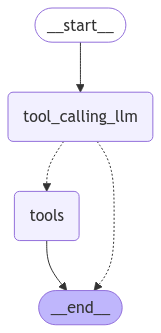

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
test_msg = [HumanMessage(content="Hello, How are you today?")]
print(tools_condition(test_msg))

__end__


In [16]:
test_msg = [HumanMessage(content="Hello, What is 8 multiplied by 5?")]
print(tools_condition(test_msg))

__end__


In [5]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2? .")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 multiplied by 2? .
================================== Ai Message ==================================
Tool Calls:
  multiply (call_89aUoj0EMLLoKg8AH0wuA3Ow)
 Call ID: call_89aUoj0EMLLoKg8AH0wuA3Ow
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


In [6]:
messages = [HumanMessage(content="Hello, what is the sum of first 10 postive numbers? .")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is the sum of first 10 postive numbers? .
================================== Ai Message ==================================

The sum of the first 10 positive numbers (1 through 10) can be calculated using the formula for the sum of an arithmetic series:

\[ \text{Sum} = \frac{n}{2} \times (\text{first term} + \text{last term}) \]

For the first 10 positive numbers:

\[ n = 10, \text{first term} = 1, \text{last term} = 10 \]

\[ \text{Sum} = \frac{10}{2} \times (1 + 10) = 5 \times 11 = 55 \]

So, the sum of the first 10 positive numbers is 55.


In [7]:
messages = [HumanMessage(content="Hello, what answer to 3,4, and 5.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what answer to 3,4, and 5.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_cEAOrXX5P8uGywg5ffFDqHM8)
 Call ID: call_cEAOrXX5P8uGywg5ffFDqHM8
  Args:
    a: 3
    b: 3
  multiply (call_891odSMCAM4BRXJWS6j8UW6k)
 Call ID: call_891odSMCAM4BRXJWS6j8UW6k
  Args:
    a: 4
    b: 4
  multiply (call_Gqa9K1QgcWXyCuBW6aQLJIs6)
 Call ID: call_Gqa9K1QgcWXyCuBW6aQLJIs6
  Args:
    a: 5
    b: 5
================================= Tool Message =================================
Name: multiply

9
================================= Tool Message =================================
Name: multiply

16
================================= Tool Message =================================
Name: multiply

25


In [19]:
messages = [""]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================


================================== Ai Message ==================================

Hello! How can I assist you today?


Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`.

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Load the `router` in Studio, which uses `module-1/studio/router.py` set in `module-1/studio/langgraph.json`.

In [24]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [32]:
def calculate(a: int, b: int, c:int) -> int:
    """Calcualtes a, b and c.

    Args:
        a: first int
        b: second int
        c: third int
    """
    return a * b + c


In [33]:
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

In [35]:
tools = [calculate,multiply, add]

In [36]:
class State(TypedDict):
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
graph_builder.add_node("tools", ToolNode(tools))
graph_builder.add_node("chatbot", lambda state: {"messages":llm.bind_tools(tools).invoke(state['messages'])})
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges(
     "chatbot", tools_condition)
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()


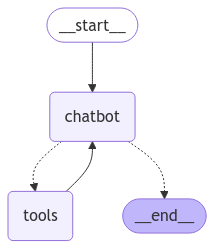

In [37]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
messages=graph.invoke({"messages": {"role": "user", "content": "What's 8 multiplied by 5, and 6 multiplied by 7?"}})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What's 8 multiplied by 5, and 6 multiplied by 7?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_4n5LFOfQrYNli4e31L5vGMAh)
 Call ID: call_4n5LFOfQrYNli4e31L5vGMAh
  Args:
    a: 8
    b: 5
  multiply (call_s3OZzoAygpqLchJh72uaCsc0)
 Call ID: call_s3OZzoAygpqLchJh72uaCsc0
  Args:
    a: 6
    b: 7
================================= Tool Message =================================
Name: multiply

40
================================= Tool Message =================================
Name: multiply

42
================================== Ai Message ==================================

8 multiplied by 5 is 40, and 6 multiplied by 7 is 42.


In [39]:
messages = [HumanMessage(content="Hello, What's 8 multiplied by 5, and added to 6?.")]
messages=graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, What's 8 multiplied by 5, and added to 6?.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_HUJSut65bK8Fzg3ppbuw1L3o)
 Call ID: call_HUJSut65bK8Fzg3ppbuw1L3o
  Args:
    a: 8
    b: 5
  add (call_X42EK9tDbOtyWi2zwbtgu3oZ)
 Call ID: call_X42EK9tDbOtyWi2zwbtgu3oZ
  Args:
    a: 40
    b: 6
================================= Tool Message =================================
Name: multiply

40
================================= Tool Message =================================
Name: add

46
================================== Ai Message ==================================

8 multiplied by 5 is 40, and when you add 6 to that, the result is 46.


In [40]:
messages = [HumanMessage(content="Hello, What's the calculation of 5,  7 and 6?.")]
messages=graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, What's the calculation of 5,  7 and 6?.
================================== Ai Message ==================================
Tool Calls:
  calculate (call_XZdVcCbujmhCPmnOqPClaAWY)
 Call ID: call_XZdVcCbujmhCPmnOqPClaAWY
  Args:
    a: 5
    b: 7
    c: 6
================================= Tool Message =================================
Name: calculate

41
================================== Ai Message ==================================

The calculation of 5, 7, and 6 is 41.
